# 개요 
* 딥러닝 스터디에 제출했던 과제에 대한 피드백 반영 및 개선(지속 개선예정)
* 원본데이터 : [Kaggle CreditCard Fraud Detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)
* 적용한 피드백
  * Keras tuner 사용시 처음부터 Learning rate를 Test대상에 포함
  * Early stopping이 아닌 전체 epoch 수행 후 최적포인트를 적용하는 방법도 해보려했으나, 학습자체에 시간이 오래걸려 제외
* 추가 테스트
  * 다른 Adam계열 Optimizer를 Keras tuner후보군에 추가
  * Early stopping에 대해 Keras callback의 ReduceLROnPlateau도 사용해봄
  * Random search, Grid Search 를 알아보다가 Hyperband라는 것도 있어서 사용해봄
    * Random search는 무작위 탐색으로 효율적이지만 최적일수도 있고 아닐수도 있음
    * Grid search는 가능한 모든 조합을 탐색하여 오래 걸림
    * 효율적이지만 최적이 아닐 확률이 있다는 점과 가정용 컴퓨터에서 계산효율적이지 못한 방법론이 맞는지에 대한 고민
    * Hyperband가 정해진 시간내에 중간 결과를 기준으로 조합 후보를 버리는 등 결합된 방법론으로 보여 적용해봄
  * 수업에 나온 Leaky ReLU도 적용해보고 싶었지만, Tuner호환 등 여러 문제가 있어 제외함
  * 학습한 모델은 저장해두고 향후 다른 것도 해보기
* 결과
  * 초보 수준에서는 Tuner가 좋은 파라미터를 정해줄 것을 기대하여 막연히 점수가 개선될 것을 기대했으나,
    실험 결과로는 유의미한 개선점이 보이지는 않았음
    * 모델평가(Stratified Fold만 적용)
      * [Train]7121/7121 - 4s - 573us/step - f1_score: 0.0071 - loss: 0.0024 - precision_7: 0.9479 - recall_7: 0.8782
      * [Test]891/891 - 1s - 598us/step - f1_score: 0.0072 - loss: 0.0033 - precision_7: 0.9000 - recall_7: 0.7347
    * 모델평가(Tuner + Learning rate scheduler + Early stopping 추가 적용)
      * [Train]8011/8011 - 6s - 741us/step - f1_score: 0.0035 - loss: 0.0151 - precision: 0.8372 - recall: 0.8126
      * [Test]891/891 - 1s - 772us/step - f1_score: 0.0034 - loss: 0.0216 - precision: 0.7600 - recall: 0.7755
  * Optimizer나 Hyperband 등 세부적인 내용의 고려 없이 적용되어 긍정적인 결과가 나오지 않은 것으로 추정


# 개선과제 진행

### Keras Tuner 사용한 딥러닝 모델 개선
* Learning rate를 처음 튜닝부터 포함
* Optimizer를 다양하게 고려 (Adam계열)
* Leaky ReLU를 Activation 후보군에 포함하려했으나, Tuner지원하지않는 것으로 보여 제외
  * Choice 함수에는 int, float, str, bool만 가능하여 아래와 같이 추가했음
  ```python
    from keras.utils import get_custom_objects
    from keras.layers import LeakyReLU
    
    get_custom_objects().update({'leaky-relu': LeakyReLU()}) # Add LeakyReLU
    activation = hp.Choice('activation'+str(i),values=['relu','elu','leaky-relu']) # For Activation
  ```
  * 그러나 아래의 오류가 계속 발생하여 제외함
  ```python
    >>> ValueError: Could not interpret activation function identifier: leaky-relu
  ```

In [ ]:
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall, F1Score
import matplotlib.pyplot as plt

In [ ]:
def build_model(hp):
    model = tf.keras.models.Sequential()

    # Input & Flatten
    model.add(tf.keras.layers.Input((29,1)))
    model.add(tf.keras.layers.Flatten())

    # Hidden Layers
    for i in range(hp.Int('num_layers',min_value=1,max_value=20)):

        # For Dense
        units = hp.Int('units',min_value=10,max_value=150,step=5) # For Neurons
        activation = hp.Choice('activation'+str(i),values=['relu','elu']) # For Activation

        model.add(tf.keras.layers.Dense(units, activation=activation,
                                        # 기본값은 glorot_uniform(Xavier), He는 Kaiming
                                        kernel_initializer=tf.keras.initializers.HeNormal())) 
        
        # Add Batch Normalization
        model.add(tf.keras.layers.BatchNormalization()) # Layer통과후 & Activation 전
        
        # For Dropout
        dropout_rate = hp.Choice('dropout'+str(i),values=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
        model.add(tf.keras.layers.Dropout(dropout_rate))

    model.add(tf.keras.layers.Dense(1, activation='sigmoid')) # 이진분류이므로 Sigmoid사용
    
    # Model setting
    hp_learning_rate = hp.Choice('learning_rate', values = [0.05, 0.01, 0.001]) 
    dict_optimizers_with_lr = {
        'Adam': tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        'Nadam': tf.keras.optimizers.Nadam(learning_rate=hp_learning_rate),
        'AdamW': tf.keras.optimizers.AdamW(learning_rate=hp_learning_rate),
        'Adamax': tf.keras.optimizers.Adamax(learning_rate=hp_learning_rate)
        }
    hp_optimizer=hp.Choice('optimizer',values=['Adam','Nadam','AdamW','Adamax'])

    model.compile(optimizer=dict_optimizers_with_lr[hp_optimizer], 
                  loss='binary_crossentropy',
                  metrics=[F1Score(average="weighted"), Precision(), Recall()])
    
    return model


with tf.device('/device:GPU:0'):    
    tuner = kt.Hyperband(build_model,
                     objective = kt.Objective('val_f1_score', direction='max'), 
                     max_epochs = 10,
                     project_name = 'test_hyperband')
    
    for idx in kfold_dataset.keys():
    ## 모델 학습
        tuner.search(kfold_dataset[idx]['x_train'],  kfold_dataset[idx]['y_train'],
                                            epochs=10,
                                            validation_data=(kfold_dataset[idx]['x_validation'], kfold_dataset[idx]['y_validation']))

Trial 30 Complete [00h 02m 29s]
val_f1_score: 0.00343498052097857

Best val_f1_score So Far: 0.4999999403953552
Total elapsed time: 00h 45m 46s


In [ ]:
tuner.get_best_hyperparameters()[0].values


{'num_layers': 4,
 'units': 105,
 'activation0': 'elu',
 'dropout0': 0.5,
 'learning_rate': 0.05,
 'optimizer': 'Nadam',
 'activation1': 'relu',
 'dropout1': 0.6,
 'activation2': 'relu',
 'dropout2': 0.9,
 'activation3': 'elu',
 'dropout3': 0.3,
 'activation4': 'relu',
 'dropout4': 0.9,
 'activation5': 'elu',
 'dropout5': 0.4,
 'activation6': 'elu',
 'dropout6': 0.3,
 'activation7': 'elu',
 'dropout7': 0.2,
 'activation8': 'elu',
 'dropout8': 0.5,
 'activation9': 'elu',
 'dropout9': 0.6,
 'activation10': 'elu',
 'dropout10': 0.5,
 'activation11': 'relu',
 'dropout11': 0.9,
 'activation12': 'elu',
 'dropout12': 0.6,
 'activation13': 'elu',
 'dropout13': 0.3,
 'activation14': 'relu',
 'dropout14': 0.5,
 'activation15': 'elu',
 'dropout15': 0.8,
 'activation16': 'elu',
 'dropout16': 0.2,
 'activation17': 'elu',
 'dropout17': 0.1,
 'activation18': 'elu',
 'dropout18': 0.2,
 'activation19': 'elu',
 'dropout19': 0.5,
 'tuner/epochs': 10,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tune

In [ ]:
model_by_tuner= tuner.get_best_models(num_models=1)[0]
model_by_tuner.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 29)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 105)            │         3,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 105)            │           420 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 105)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 105)            │        11,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 105)            │           420 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 105)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 105)            │        11,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 105)            │           420 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 105)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 105)            │        11,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 105)            │           420 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 105)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           106 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,326 (149.71 KB)

 Trainable params: 37,486 (146.43 KB)

 Non-trainable params: 840 (3.28 KB)

### 딥러닝 모델에 Learning rate scheduler와 Early stopping 적용
* Learning rate scheduler와 Early stopping 모두 weighted f1-score는 지원하지 않아, val_f1-score로 사용
```python
    UserWarning: Learning rate reduction is conditioned on metric `<F1Score name=f1_score>` 
    which is not available. Available metrics are
    : f1_score,loss,precision,recall,val_f1_score,val_loss,val_precision,val_recall,learning_rate.
    UserWarning: Early stopping conditioned on metric `<F1Score name=f1_score>` 
    which is not available. Available metrics are
    : f1_score,loss,precision,recall,val_f1_score,val_loss,val_precision,val_recall,learning_rate
```

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
import numpy as np
import keras
import matplotlib.pyplot as plt

In [ ]:
total_epoch_value = 1000

with tf.device('/device:GPU:0'):
    reduce_lr = ReduceLROnPlateau(monitor='val_f1_score',
                factor=0.2, # lr감소치. 현재 lr이 0.01이라면 0.01*0.2를 적용
                patience=10, # 개선에 대한 허용치. 10 epoch까지 개선이 없다면 적용
                mode='max', # auto, max, min 옵션 있음
                min_lr=0.001)
    es = EarlyStopping(monitor='val_f1_score', mode='max', verbose=1, patience=200)

    # 모델 학습
    for idx in kfold_dataset.keys():
        history_tuner = model_by_tuner.fit(kfold_dataset[idx]['x_train'],  kfold_dataset[idx]['y_train'], 
                                        epochs=total_epoch_value,
                                        callbacks=[reduce_lr, es],
                                        validation_data=(kfold_dataset[idx]['x_validation'], kfold_dataset[idx]['y_validation']))

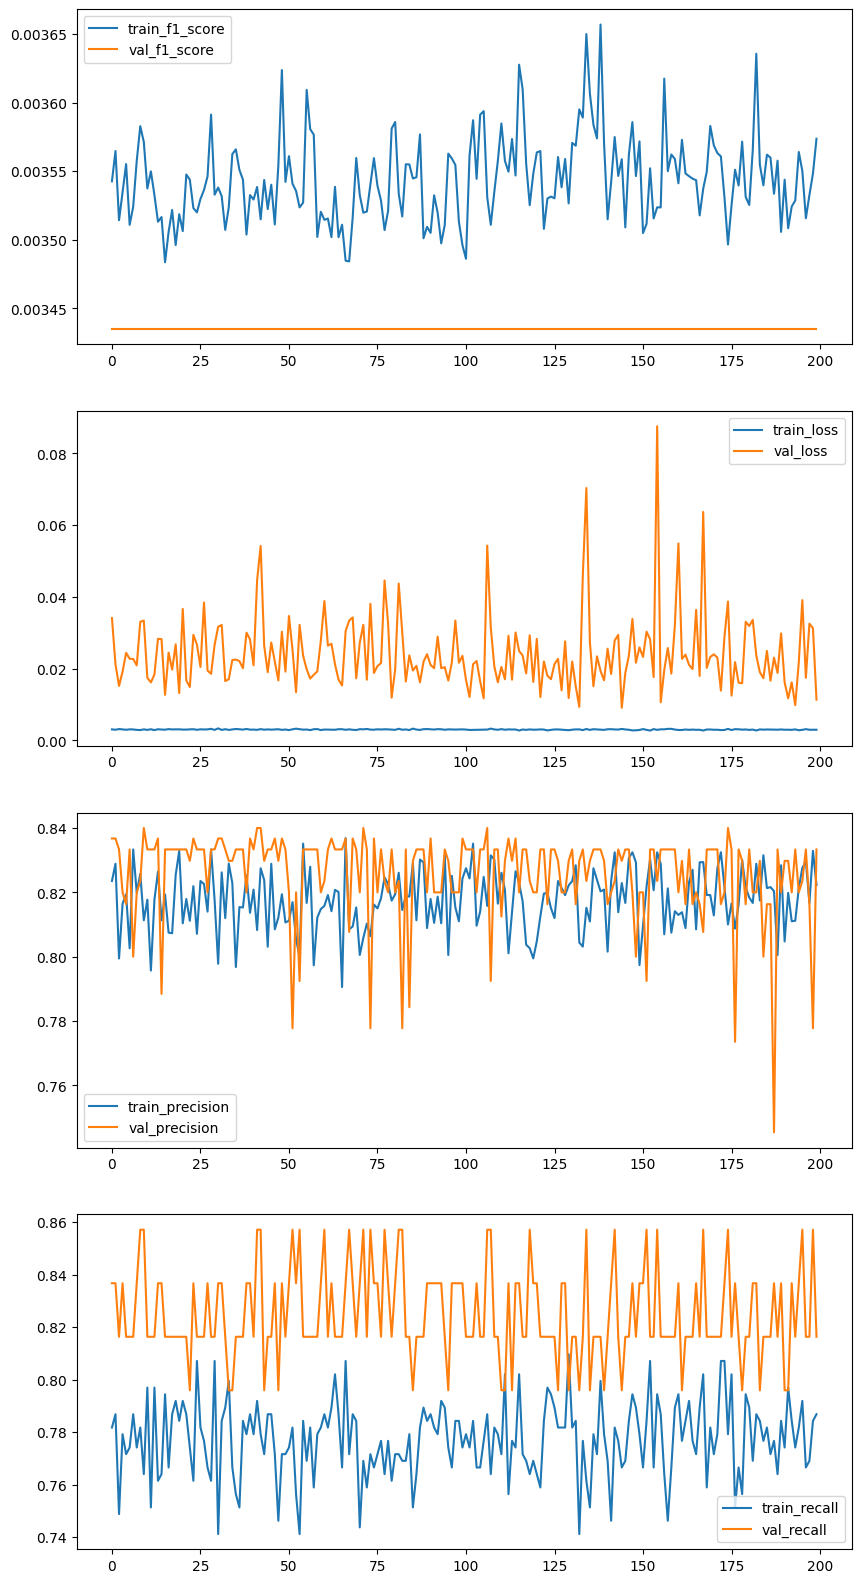

In [ ]:
# 시각화
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(10,20))

for idx, key in enumerate(history_tuner.history.keys()):
    if idx == 4:
        break
    axs[idx].plot(history_tuner.history[key], label=f"train_{key}")
    axs[idx].plot(history_tuner.history[f"val_{key}"], label=f"val_{key}")
    axs[idx].legend()

plt.show()

In [ ]:
# 모델 평가
print('* 모델평가')
model_by_tuner.evaluate(x_train, y_train, verbose=2)
model_by_tuner.evaluate(x_test, y_test, verbose=2)

* 모델평가
8011/8011 - 6s - 741us/step - f1_score: 0.0035 - loss: 0.0151 - precision: 0.8372 - recall: 0.8126
891/891 - 1s - 772us/step - f1_score: 0.0034 - loss: 0.0216 - precision: 0.7600 - recall: 0.7755


[0.02163444086909294,
 0.00343498052097857,
 0.7599999904632568,
 0.7755101919174194]

* 모델평가(Stratified Fold만 적용)
  * 7121/7121 - 4s - 573us/step - f1_score: 0.0071 - loss: 0.0024 - precision_7: 0.9479 - recall_7: 0.8782
  * 891/891 - 1s - 598us/step - f1_score: 0.0072 - loss: 0.0033 - precision_7: 0.9000 - recall_7: 0.7347

* 모델평가(Tuner + Learning rate scheduler + Early stopping 추가 적용)
  * 8011/8011 - 6s - 741us/step - f1_score: 0.0035 - loss: 0.0151 - precision: 0.8372 - recall: 0.8126
  * 891/891 - 1s - 772us/step - f1_score: 0.0034 - loss: 0.0216 - precision: 0.7600 - recall: 0.7755

### 학습한 모델 저장

In [ ]:
model_by_tuner.save('model_by_tuner_fitted.keras')

In [ ]:
loadedm_model = keras.models.load_model('model_by_tuner.keras')
print('* 모델평가')
loadedm_model.evaluate(x_train, y_train, verbose=2)
loadedm_model.evaluate(x_test, y_test, verbose=2)

* 모델평가
8011/8011 - 8s - 1ms/step - f1_score: 0.0035 - loss: 0.0151 - precision: 0.8372 - recall: 0.8126
891/891 - 1s - 786us/step - f1_score: 0.0034 - loss: 0.0216 - precision: 0.7600 - recall: 0.7755


[0.02163444086909294,
 0.00343498052097857,
 0.7599999904632568,
 0.7755101919174194]